In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import time

# Data Processing

In [44]:
## load the data

# track metadata
tf = pd.read_csv("tf_mini.csv")

# listening sessions and associated user actions
ts = pd.read_csv("log_mini.csv")

In [45]:
## deal with track features

tf['mode'] = tf['mode'].replace({      #replace 'mode' to dummy
    'major': 1,
    'minor': 0
})

tf['release_year'] =tf['release_year']-np.mean(tf['release_year'])   #standadise 'released year'
tf['release_year']/=np.std(tf['release_year'])

tf['duration'] =tf['duration']-np.mean(tf['duration'])                     #standadise 'duration'
tf['duration']/=np.std(tf['duration'])

tf['us_popularity_estimate'] =tf['us_popularity_estimate']-np.mean(tf['us_popularity_estimate'])   #standadise 'us popularity estimate'
tf['us_popularity_estimate']/=np.std(tf['us_popularity_estimate'])


# track features matrix
track = np.array(tf.iloc[:,1:]).astype("float")


# deal with user information
ts = ts.drop(['session_length','skip_1','skip_3','not_skipped',                                # drop the interaction information after a track has been shown
                            'date','hour_of_day','hist_user_behavior_n_seekback',
                            'hist_user_behavior_n_seekfwd','hist_user_behavior_reason_end'],axis = 1)

ts = ts.applymap(lambda x: 1 if x == True else x)      # boolean to integer
ts = ts.applymap(lambda x: 0 if x == False else x)

ts['user_behavior'] = ts['skip_2'].replace([1,0],[0,1])      # define user behavior


# get dummy variables
context_dummy = pd.get_dummies(ts.context_type, prefix = 'context_type').iloc[:,1:]
start_dummy = pd.get_dummies(ts.hist_user_behavior_reason_start, prefix = 'hist_user_behavior_reason_start').iloc[:,1:]

ts = pd.concat([ts,context_dummy,start_dummy],axis = 1).drop(['context_type','hist_user_behavior_reason_start' ], axis = 1)



In [46]:
#ts = ts.iloc[:1982,:]
ts = ts.iloc[:16010,:]  

In [47]:
       # a subset to 

In [48]:
track_id_dict={}
for i,track_id in enumerate(tf.track_id):
    track_id_dict[track_id]=i
    
for i,track_id in enumerate(ts.track_id_clean):
    if i%10000==0:
        i=i
    try:
        track_id_dict[track_id]
    except:
        i=i
        
session_id_dict={}
i=0
for session_id in ts.session_id:
    try:
        session_id_dict[session_id]
    except:
        session_id_dict[session_id]=i
        i+=1

user_id_index = [session_id_dict[j] for j in ts.session_id]
track_id_index = [track_id_dict[j] for j in ts.track_id_clean]

ts['user_id_index'] = user_id_index
ts['track_id_index'] = track_id_index

In [49]:
# combine two datasets
ts = ts.rename(columns = {'track_id_clean':'track_id'})
full_data = pd.merge(ts,tf)
full_data.sort_values(by = ['session_id','session_position'],inplace=True)

In [50]:
# split dataset into training and test sets
train_data, test_data = train_test_split(full_data,test_size=0.25)


In [51]:
# training set of PMF
R=np.full([len(session_id_dict.keys()),len(track_id_dict.keys())],np.nan)
for line in train_data.itertuples():
    R[line[25], line[26]] = line[11]  
    
# test set of PMF
T =np.full([len(session_id_dict.keys()),len(track_id_dict.keys())],np.nan)
for line in test_data.itertuples():
    T[line[25], line[26]] = line[11]

observed = 1 - np.isnan(T)
test_pmf = T[~np.isnan(T)]

In [52]:

# training set of logistic regression
X_train_global = train_data.drop(['session_id','session_position', 'track_id', 'skip_2','user_behavior',
       'user_id_index', 'track_id_index'], axis = 1)
X_train_ut = np.asarray(X_train_global)

X_train_user = np.asarray(X_train_global.iloc[:,:19])
X_train_track = np.asarray(X_train_global.iloc[:,19:])

y_train = np.asarray(train_data['user_behavior'])

# test set
X_test_global = pd.get_dummies(test_data.drop(['session_id','session_position', 'track_id', 'skip_2','user_behavior',
       'user_id_index', 'track_id_index'], axis = 1))
X_test_ut = np.asarray(X_test_global)

X_test_user = np.asarray(X_test_global.iloc[:,:19])
X_test_track = np.asarray(X_test_global.iloc[:,19:])

y_test = np.asarray(test_data['user_behavior'])


# training and test sets for PMF with user
X_train_pmf = np.asarray(pd.concat([X_train_global,train_data['session_id']], axis=1))
X_test_pmf = np.asarray(pd.concat([X_test_global,test_data['session_id']], axis=1))

# Probabilistic Matrix Factorisation model

## PMF1

In [53]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return(y)


class LogisticMF_without_track():

    def __init__(self, counts, reg_param=0.6, gamma=1, 
                 iterations=100):
        self.counts = counts
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.iterations = iterations
        self.reg_param = reg_param
        self.gamma = gamma
        self.lost_list = []

    def train_model(self):
        self.user_vectors = np.random.normal(size=(self.num_users,1))
        self.item_vectors = np.random.normal(size=(self.num_items,1))
        
        
        user_vec_deriv_sum = np.zeros((self.num_users, 1))
        item_vec_deriv_sum = np.zeros((self.num_items, 1))
        
        for i in range(self.iterations):
            t0 = time.time()
            
            # Fix items and solve for users
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            
            user_vec_deriv = self.deriv(True)
            
            # step size
            user_vec_deriv_sum += np.square(user_vec_deriv)
            vec_step_size = self.gamma / np.sqrt(user_vec_deriv_sum)
        
            
            # update user vector
            self.user_vectors += vec_step_size * user_vec_deriv


            # Fix users and solve for items
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            
            item_vec_deriv = self.deriv(False)
            
            # step size
            item_vec_deriv_sum += np.square(item_vec_deriv)
            vec_step_size = self.gamma / np.sqrt(item_vec_deriv_sum)
            
            # update item vector
            self.item_vectors += vec_step_size * item_vec_deriv
            

            print(self.log_likelihood())
            self.lost_list.append(self.log_likelihood())
            t1 = time.time()

            print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
            
        plt.figure()
        plt.plot(self.lost_list)
        plt.xlabel('iteration')
        plt.ylabel('log-likelihood')
        plt.show()

    def deriv(self, user):
        # probability matrix
        M = np.dot(self.user_vectors,self.item_vectors.T)
        P = sigmoid(M)
        
        if user:
            vec_deriv = np.dot(np.where(np.isnan(self.counts-P),0,self.counts-P),self.item_vectors)              
            # L2 regularization
            vec_deriv -= self.reg_param * self.user_vectors
            
        else:
            vec_deriv = np.dot(np.where(np.isnan((self.counts-P).T),0,(self.counts-P).T), self.user_vectors)              
            # L2 regularization
            vec_deriv -= self.reg_param * self.item_vectors
        return (vec_deriv)

    def log_likelihood(self):
        
        M = np.dot(self.user_vectors,self.item_vectors.T)
        P = sigmoid(M)
        
        A = np.log(P) * self.counts
       
        B = (1-self.counts) * np.log(1-P)
        loglik = np.nansum(A+B)

        # L2 regularization
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.user_vectors))
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.item_vectors))
        return loglik




## PMF2

In [54]:


class LogisticMF_with_track():

    def __init__(self, counts, reg_param, gamma=0.8,  
                 iterations=100):
        self.counts = counts
        self.num_users = counts.shape[0]
        self.num_items = track.shape[1]
        self.iterations = iterations
        self.reg_param = reg_param
        self.gamma = gamma

    def train_model(self):
        self.user_vectors = np.random.normal(size=(self.num_users,1))
        self.item_vectors = np.random.normal(size=(self.num_items,1))
        user_vec_deriv_sum = np.zeros((self.num_users, 1))
        item_vec_deriv_sum = np.zeros((self.num_items, 1))
        
        lost_list = []
        for i in range(self.iterations):
            t0 = time.time()
            
            # Fix items and solve for users
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            
            user_vec_deriv = self.deriv(True)
            
            # step size
            user_vec_deriv_sum += np.square(user_vec_deriv)
            vec_step_size = self.gamma / np.sqrt(user_vec_deriv_sum)
        
            
            # update user vector
            self.user_vectors += vec_step_size * user_vec_deriv


            # Fix users and solve for items
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            
            item_vec_deriv = self.deriv(False)
            
            # step size
            item_vec_deriv_sum += np.square(item_vec_deriv)
            vec_step_size = self.gamma / np.sqrt(item_vec_deriv_sum)
            
            # update item vector
            self.item_vectors += vec_step_size * item_vec_deriv
            
            
            print(self.log_likelihood())
            lost_list.append(self.log_likelihood())
            t1 = time.time()
            


            print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
        plt.figure()
        plt.plot(lost_list)
        plt.xlabel('iteration')
        plt.ylabel('log-likelihood')
        plt.show()

    def deriv(self, user):
        # probability matrix
        M = self.user_vectors.dot(np.dot(self.item_vectors.T,track.T))
        P = sigmoid(M)
        
        if user:
            vec_deriv = np.dot( np.where(np.isnan(self.counts-P),0,self.counts-P),track.dot(self.item_vectors))               
            # L2 regularization
            vec_deriv -= self.reg_param * self.user_vectors
            
        else:
            vec_deriv = np.dot(track.T,np.where(np.isnan((self.counts-P).T),0,(self.counts-P).T)).dot(self.user_vectors)              
            # L2 regularization
            vec_deriv -= self.reg_param * self.item_vectors
        return (vec_deriv)

    def log_likelihood(self):
        
        M = self.user_vectors.dot(np.dot(self.item_vectors.T,track.T))
        P = sigmoid(M)
        
        A = np.log(P) * self.counts
       
        B = (1-self.counts) * np.log(1-P)
        loglik = np.nansum(A+B)

        # L2 regularization
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.user_vectors))
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.item_vectors))
        return loglik

## PMF3

In [55]:

lost_list = []
def grad_descent(X,Y,session_id_dict,lamda):
    n = X.shape[1]
    
    m = len(session_id_dict)
    
    U = np.random.normal(size=(m,1))/100
    theta = np.random.normal(size=(n-1,1))

    gui = np.zeros((m,1))

    maxCycle = 100         # iteration times
    gammer = 0.00001     # learning rate
  
    
    lost = []
    for i in range(maxCycle):
        
        g_theta = 0
        to = time.time()
        for j,k in session_id_dict.items():
            
            
            xi = X[X[:,-1]==j]
            yi = Y[X[:,-1]==j]
            
            xi = np.mat(xi[:,0:-1])  
            yi = np.mat(yi)         
            yi = yi.transpose()

            z = np.mat(U[k][0]*xi*theta,dtype=float)                               
            p = sigmoid(z)
            aa = yi-p

            gui[k] = aa.T*(xi*theta)-lamda*U[k]
      
            U[k] = U[k] + gammer*gui[k] 
    
            g_theta = g_theta+(aa.T*xi).T*U[k]
          
            UU = [U[session_id_dict[j]] for j in X[:,-1]]
            UU = np.mat(UU,dtype = float)

            
        theta = theta + gammer*g_theta
        theta = np.array(theta)

        tc = time.time()
        print ('iteration %i finished in %f seconds' % (i + 1, tc-to))
        

        Xfai = np.mat(np.dot(X[:,:-1], theta),dtype = float)
        P = sigmoid(np.multiply(UU,Xfai))
        ### calculate the L and print
        loglik = np.sum(np.multiply(np.mat(Y).T ,np.log(P)) +np.multiply(np.mat(1-Y).T,np.log(1-P))) -0.5*lamda*np.sum(np.square(U)) - 0.5*lamda*np.sum(np.square(theta))
        print(loglik)
        lost.append(loglik)
    plt.figure()
    plt.plot(lost)
    plt.xlabel('iteration')
    plt.ylabel('log-likelihood')
    plt.show()

    return(theta,U)

## Select regularization parameters

-6740.179162861245
iteration 1 finished in 20.503375 seconds
-4575.109210010609
iteration 2 finished in 18.346404 seconds
-3830.6781149362314
iteration 3 finished in 13.335556 seconds
-3530.8442916286244
iteration 4 finished in 14.200850 seconds
-3374.73312944243
iteration 5 finished in 13.462026 seconds
-3278.989621139649
iteration 6 finished in 13.608184 seconds
-3218.719627830648
iteration 7 finished in 13.481069 seconds
-3176.260499307669
iteration 8 finished in 13.765519 seconds
-3140.2641655222756
iteration 9 finished in 13.223685 seconds
-3111.0528005127385
iteration 10 finished in 13.700550 seconds
-3084.526678108392
iteration 11 finished in 13.563447 seconds
-3066.1416169415293
iteration 12 finished in 13.509930 seconds
-3053.3132493567005
iteration 13 finished in 13.675666 seconds
-3042.165618909541
iteration 14 finished in 13.827039 seconds
-3033.869925458605
iteration 15 finished in 13.539029 seconds
-3027.1461107510445
iteration 16 finished in 13.391383 seconds
-3021.88601

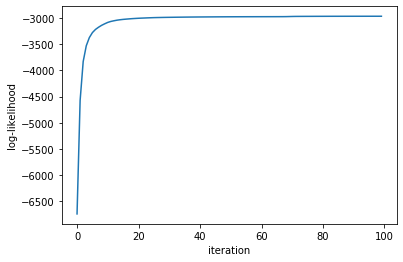

-9260.282851783155
iteration 1 finished in 16.929663 seconds
-5864.642563719433
iteration 2 finished in 16.457879 seconds
-4998.647642056587
iteration 3 finished in 15.990919 seconds
-4613.03483442544
iteration 4 finished in 14.408580 seconds
-4428.414353875811
iteration 5 finished in 14.451593 seconds
-4323.763938755546
iteration 6 finished in 14.776386 seconds
-4259.50125470409
iteration 7 finished in 14.169134 seconds
-4217.045466814688
iteration 8 finished in 14.059350 seconds
-4188.562382924811
iteration 9 finished in 14.766488 seconds
-4168.595171616695
iteration 10 finished in 15.802877 seconds
-4151.731386835644
iteration 11 finished in 17.386753 seconds
-4138.3302712994255
iteration 12 finished in 16.169079 seconds
-4127.09270219778
iteration 13 finished in 15.244125 seconds
-4119.066411009957
iteration 14 finished in 16.620243 seconds
-4111.802391177317
iteration 15 finished in 16.867687 seconds
-4106.270682628732
iteration 16 finished in 18.464852 seconds
-4100.576892198124


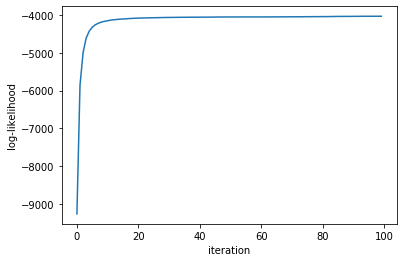

-11618.597824695407
iteration 1 finished in 18.139456 seconds
-6836.3095324197475
iteration 2 finished in 16.102806 seconds
-5889.09807939018
iteration 3 finished in 17.258994 seconds
-5460.473129145671
iteration 4 finished in 1834.125134 seconds
-5242.2882988073925
iteration 5 finished in 17.246120 seconds
-5113.56525441396
iteration 6 finished in 15.395701 seconds
-5030.205669305543
iteration 7 finished in 14.783413 seconds
-4981.56693765829
iteration 8 finished in 14.603780 seconds
-4949.09342521525
iteration 9 finished in 15.312369 seconds
-4925.635499971841
iteration 10 finished in 14.806825 seconds
-4908.0466347594265
iteration 11 finished in 14.602432 seconds
-4893.901280867623
iteration 12 finished in 13.898404 seconds
-4882.480122264939
iteration 13 finished in 13.832068 seconds
-4870.631992936712
iteration 14 finished in 14.216523 seconds
-4861.459012732718
iteration 15 finished in 15.836651 seconds
-4853.40343957223
iteration 16 finished in 4598.654322 seconds
-4846.93900449

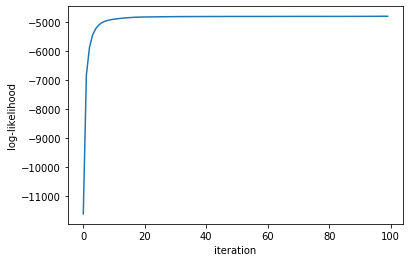

-13926.650255233215
iteration 1 finished in 16.746709 seconds
-7529.619188622234
iteration 2 finished in 13.821739 seconds
-6423.357754931729
iteration 3 finished in 13.727015 seconds
-5967.073418578821
iteration 4 finished in 14.328178 seconds
-5748.7706075587075
iteration 5 finished in 13.702011 seconds
-5630.940181141551
iteration 6 finished in 13.628211 seconds
-5558.921198238732
iteration 7 finished in 15.915994 seconds
-5513.558465000062
iteration 8 finished in 13.635868 seconds
-5481.357484316944
iteration 9 finished in 13.482163 seconds
-5458.123421999648
iteration 10 finished in 13.987759 seconds
-5442.7545760361945
iteration 11 finished in 13.982039 seconds
-5432.399001773786
iteration 12 finished in 13.665742 seconds
-5425.204399354683
iteration 13 finished in 13.928690 seconds
-5419.39309166901
iteration 14 finished in 13.557736 seconds
-5415.088540410777
iteration 15 finished in 13.443701 seconds
-5411.427297473343
iteration 16 finished in 13.467352 seconds
-5407.960789618

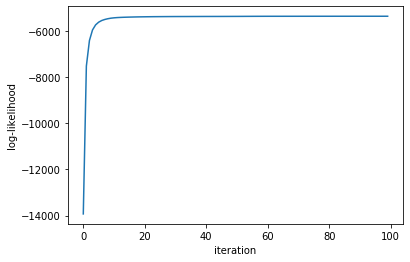

-16075.410309795217
iteration 1 finished in 16.257600 seconds
-8072.075613063516
iteration 2 finished in 14.408416 seconds
-6845.412820529131
iteration 3 finished in 17.813916 seconds
-6394.559330603846
iteration 4 finished in 17.723944 seconds
-6182.311517141931
iteration 5 finished in 16.105653 seconds
-6067.001413592642
iteration 6 finished in 15.925996 seconds
-5999.254150596798
iteration 7 finished in 15.510082 seconds
-5955.91447492901
iteration 8 finished in 14.039026 seconds
-5926.434864076666
iteration 9 finished in 13.497126 seconds
-5904.594344507734
iteration 10 finished in 14.086590 seconds
-5888.086332863939
iteration 11 finished in 14.520846 seconds
-5875.927409658673
iteration 12 finished in 14.663667 seconds
-5866.388844587825
iteration 13 finished in 14.212204 seconds
-5858.730487463131
iteration 14 finished in 14.072838 seconds
-5852.439292278819
iteration 15 finished in 14.160893 seconds
-5847.103981950449
iteration 16 finished in 14.679983 seconds
-5842.60146620370

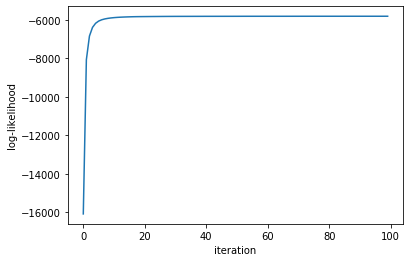

/Users/ruixue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log
/Users/ruixue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply


-inf
iteration 1 finished in 19.918000 seconds
-inf
iteration 2 finished in 15.633431 seconds
-inf
iteration 3 finished in 15.822203 seconds
-inf
iteration 4 finished in 16.091551 seconds
-inf
iteration 5 finished in 16.922361 seconds
-7687.591873997636
iteration 6 finished in 16.243984 seconds
-6778.803006779748
iteration 7 finished in 15.773435 seconds
-6571.152490339816
iteration 8 finished in 15.825534 seconds
-6218.4755234564245
iteration 9 finished in 15.991352 seconds
-6091.941706199677
iteration 10 finished in 16.612544 seconds
-5945.239012984845
iteration 11 finished in 16.031988 seconds
-5838.346501792458
iteration 12 finished in 15.989992 seconds
-5732.475709507936
iteration 13 finished in 15.822416 seconds
-5654.892112348754
iteration 14 finished in 15.738425 seconds
-5591.060164675289
iteration 15 finished in 15.687372 seconds
-5535.9729742762165
iteration 16 finished in 16.033277 seconds
-5496.571090632422
iteration 17 finished in 15.767598 seconds
-5457.371041946819
iter

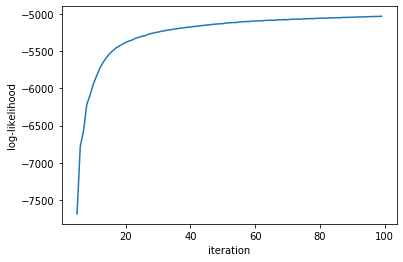

-inf
iteration 1 finished in 22.406237 seconds
-inf
iteration 2 finished in 14.925256 seconds
-15803.250716406012
iteration 3 finished in 15.630865 seconds
-inf
iteration 4 finished in 15.340992 seconds
-10550.18365043547
iteration 5 finished in 15.337247 seconds
-6455.163460791531
iteration 6 finished in 15.225285 seconds
-6182.382413355253
iteration 7 finished in 15.695127 seconds
-6013.297733057729
iteration 8 finished in 15.579454 seconds
-5872.849029458825
iteration 9 finished in 15.385689 seconds
-5769.731330658971
iteration 10 finished in 15.362447 seconds
-5683.009171761218
iteration 11 finished in 15.326239 seconds
-5612.981493632202
iteration 12 finished in 15.515662 seconds
-5553.834878567497
iteration 13 finished in 15.492931 seconds
-5503.87826220328
iteration 14 finished in 15.780286 seconds
-5461.174095882344
iteration 15 finished in 18.222448 seconds
-5424.420892502132
iteration 16 finished in 15.910888 seconds
-5392.366451253291
iteration 17 finished in 15.615007 secon

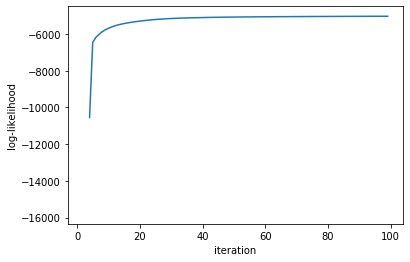

-inf
iteration 1 finished in 27.505755 seconds
-inf
iteration 2 finished in 17.920522 seconds
-inf
iteration 3 finished in 18.133748 seconds
-inf
iteration 4 finished in 26.543933 seconds
-8637.096173318045
iteration 5 finished in 20.073181 seconds
-7572.159647964042
iteration 6 finished in 17.205540 seconds
-7009.566123392943
iteration 7 finished in 15.983121 seconds
-6587.202009952581
iteration 8 finished in 15.778997 seconds
-6357.896720908004
iteration 9 finished in 21.185511 seconds
-6127.459456561122
iteration 10 finished in 28.274656 seconds
-5981.548340535473
iteration 11 finished in 17.610718 seconds
-5882.807621742239
iteration 12 finished in 16.310948 seconds
-5772.705067585476
iteration 13 finished in 16.885693 seconds
-5696.5644312977665
iteration 14 finished in 20.687892 seconds
-5645.725623788483
iteration 15 finished in 18.220729 seconds
-5574.631902648789
iteration 16 finished in 16.202521 seconds
-5531.92894443364
iteration 17 finished in 16.275315 seconds
-5471.44619

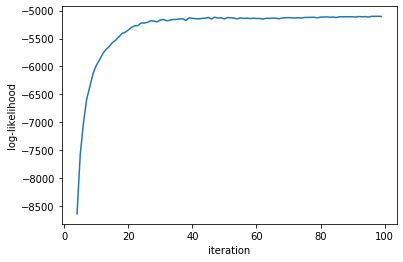

-inf
iteration 1 finished in 22.129419 seconds
-inf
iteration 2 finished in 18.279801 seconds
-inf
iteration 3 finished in 17.742406 seconds
-17026.73569718894
iteration 4 finished in 16.909600 seconds
-inf
iteration 5 finished in 17.351841 seconds
-8700.822952089338
iteration 6 finished in 16.592215 seconds
-8237.951697359335
iteration 7 finished in 17.881243 seconds
-7371.253780696737
iteration 8 finished in 21.235671 seconds
-7147.022342407927
iteration 9 finished in 17.398974 seconds
-6804.259453714871
iteration 10 finished in 16.059522 seconds
-6621.890978370655
iteration 11 finished in 23.045068 seconds
-6430.313591204055
iteration 12 finished in 18.188524 seconds
-6278.021877324275
iteration 13 finished in 16.085425 seconds
-6139.883844862045
iteration 14 finished in 15.926657 seconds
-6021.965390956175
iteration 15 finished in 17.385083 seconds
-5919.8499827873
iteration 16 finished in 16.082822 seconds
-5831.953815500468
iteration 17 finished in 16.040571 seconds
-5756.0194818

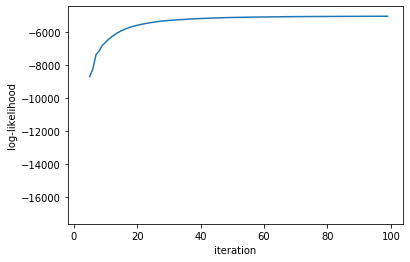

-inf
iteration 1 finished in 27.130867 seconds
-inf
iteration 2 finished in 16.658698 seconds
-18540.57636798763
iteration 3 finished in 16.495298 seconds
-inf
iteration 4 finished in 15.663341 seconds
-11956.072070550557
iteration 5 finished in 14.780330 seconds
-6448.228980309746
iteration 6 finished in 14.807311 seconds
-6239.992191815389
iteration 7 finished in 16.336358 seconds
-6096.281482094714
iteration 8 finished in 16.017648 seconds
-5958.022327381555
iteration 9 finished in 15.272725 seconds
-5862.2915387299
iteration 10 finished in 15.466114 seconds
-5762.011192733857
iteration 11 finished in 16.056910 seconds
-5690.849735629673
iteration 12 finished in 16.208465 seconds
-5617.280072045001
iteration 13 finished in 16.171134 seconds
-5562.003200106465
iteration 14 finished in 16.759481 seconds
-5508.139541417462
iteration 15 finished in 16.345000 seconds
-5464.218130769928
iteration 16 finished in 16.116399 seconds
-5423.12489006407
iteration 17 finished in 16.214598 seconds

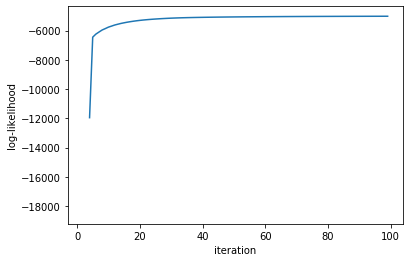

iteration 1 finished in 16.641702 seconds
-7526.820181121692
iteration 2 finished in 16.850283 seconds
-7468.484086193117
iteration 3 finished in 16.082195 seconds
-7414.50981377049
iteration 4 finished in 16.291965 seconds
-7361.552718422927
iteration 5 finished in 16.732655 seconds
-7307.1243763563
iteration 6 finished in 16.275317 seconds
-7249.349805750406
iteration 7 finished in 15.983553 seconds
-7186.853208038219
iteration 8 finished in 16.452409 seconds
-7118.724052775855
iteration 9 finished in 16.836127 seconds
-7044.530327611299
iteration 10 finished in 16.296971 seconds
-6964.350241585639
iteration 11 finished in 16.482298 seconds
-6878.794123065385
iteration 12 finished in 16.331209 seconds
-6788.989853780599
iteration 13 finished in 19.284747 seconds
-6696.5120151025085
iteration 14 finished in 21.085349 seconds
-6603.248696008572
iteration 15 finished in 21.054756 seconds
-6511.218407174125
iteration 16 finished in 26.374196 seconds
-6422.366678569481
iteration 17 finish

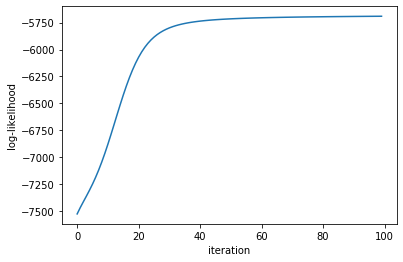

iteration 1 finished in 17.948035 seconds
-7655.926097156556
iteration 2 finished in 17.882139 seconds
-7201.120763295553
iteration 3 finished in 18.159443 seconds
-6865.132145483208
iteration 4 finished in 19.381682 seconds
-6606.503905828294
iteration 5 finished in 22.457543 seconds
-6403.881851871126
iteration 6 finished in 18.528902 seconds
-6244.589259839009
iteration 7 finished in 17.878582 seconds
-6119.790616821794
iteration 8 finished in 17.919654 seconds
-6022.560301860279
iteration 9 finished in 18.004032 seconds
-5947.184125066229
iteration 10 finished in 18.289378 seconds
-5888.9243556882975
iteration 11 finished in 17.981991 seconds
-5843.915837752325
iteration 12 finished in 17.952523 seconds
-5809.07322034657
iteration 13 finished in 18.024953 seconds
-5781.983286476488
iteration 14 finished in 17.893280 seconds
-5760.789218752019
iteration 15 finished in 17.816902 seconds
-5744.079168010231
iteration 16 finished in 17.983293 seconds
-5730.787764215551
iteration 17 fini

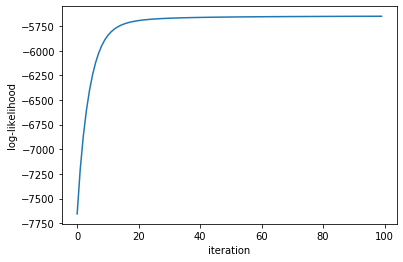

iteration 1 finished in 24.581929 seconds
-6615.9154903895005
iteration 2 finished in 28.621715 seconds
-5918.231351457171
iteration 3 finished in 24.137712 seconds
-5843.5758531726015
iteration 4 finished in 17.839922 seconds
-5800.4504425077075
iteration 5 finished in 17.882202 seconds
-5819.469453389601
iteration 6 finished in 17.865080 seconds
-5796.225472307944
iteration 7 finished in 17.919395 seconds
-5826.01513031533
iteration 8 finished in 17.961936 seconds
-5803.965839808728
iteration 9 finished in 19.452055 seconds
-5837.128821094629
iteration 10 finished in 18.294343 seconds
-5806.94712579305
iteration 11 finished in 23.534588 seconds
-5842.602127928839
iteration 12 finished in 24.885401 seconds
-5811.280977631166
iteration 13 finished in 18.110028 seconds
-5848.749284080061
iteration 14 finished in 17.918876 seconds
-5816.0046953774
iteration 15 finished in 17.893396 seconds
-5854.71897274718
iteration 16 finished in 17.923462 seconds
-5820.309886303993
iteration 17 finish

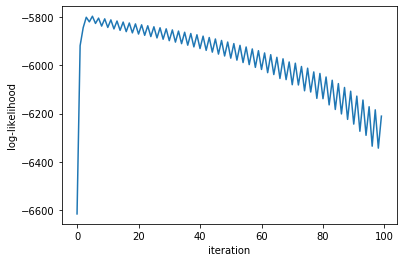

iteration 1 finished in 33.052707 seconds
-7244.324914819402
iteration 2 finished in 28.735555 seconds
-6443.25819912274
iteration 3 finished in 30.007539 seconds
-6100.112934386327
iteration 4 finished in 27.724158 seconds
-5934.139466812586
iteration 5 finished in 19.908857 seconds
-5845.550533797345
iteration 6 finished in 18.508757 seconds
-5794.3382268687
iteration 7 finished in 18.592475 seconds
-5762.706601430644
iteration 8 finished in 18.612743 seconds
-5742.055312298697
iteration 9 finished in 18.427009 seconds
-5727.925785569949
iteration 10 finished in 18.291828 seconds
-5717.864893841965
iteration 11 finished in 20.164907 seconds
-5710.451683038239
iteration 12 finished in 21.261249 seconds
-5704.82529460887
iteration 13 finished in 18.756442 seconds
-5700.443384881437
iteration 14 finished in 26.118476 seconds
-5696.952457830227
iteration 15 finished in 57.373793 seconds
-5694.115182267369
iteration 16 finished in 40.333916 seconds
-5691.768020846626
iteration 17 finished

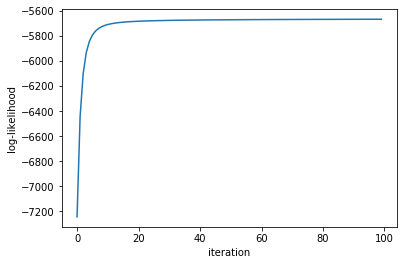

iteration 1 finished in 18.410263 seconds
-6898.27406706211
iteration 2 finished in 17.978210 seconds
-6207.657859763573
iteration 3 finished in 17.983061 seconds
-6142.01352257873
iteration 4 finished in 18.081062 seconds
-6153.444792811542
iteration 5 finished in 17.967720 seconds
-6146.447646728296
iteration 6 finished in 18.206516 seconds
-6140.637182419963
iteration 7 finished in 18.004284 seconds
-6158.89487208142
iteration 8 finished in 18.057206 seconds
-6194.713133053015
iteration 9 finished in 18.065060 seconds
-6191.563512937893
iteration 10 finished in 18.050938 seconds
-6188.421909240712
iteration 11 finished in 17.939454 seconds
-6204.696909066363
iteration 12 finished in 17.960699 seconds
-6244.801780663045
iteration 13 finished in 20.258449 seconds
-6236.235739568286
iteration 14 finished in 21.361408 seconds
-6226.800011623326
iteration 15 finished in 18.298582 seconds
-6248.585136942694
iteration 16 finished in 18.106609 seconds
-6288.276592632455
iteration 17 finishe

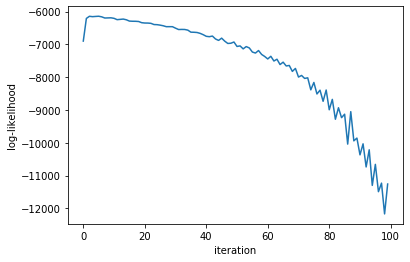

In [56]:
# train-validation split on training set
train_PMF, valid_PMF = train_test_split(train_data,test_size=0.1)


R_train =np.full([len(session_id_dict.keys()),len(track_id_dict.keys())],np.nan)
for line in train_PMF.itertuples():
    R_train[line[25], line[26]] = line[11]  
    
T_valid =np.full([len(session_id_dict.keys()),len(track_id_dict.keys())],np.nan)
for line in valid_PMF.itertuples():
    T_valid[line[25], line[26]] = line[11]
    
observe_PMF = 1 - np.isnan(T_valid)
validation_PMF = T_valid[~np.isnan(T_valid)]


X_train_global_PMF = train_PMF.drop(['session_id','session_position', 'track_id', 'skip_2','user_behavior',
       'user_id_index', 'track_id_index'], axis = 1)
X_train_PMF = np.asarray(pd.concat([X_train_global_PMF, train_PMF['session_id']], axis=1))
y_train_PMF = np.asarray(train_PMF['user_behavior'])

X_val_global_PMF = pd.get_dummies(valid_PMF.drop(['session_id','session_position', 'track_id', 'skip_2','user_behavior',
       'user_id_index', 'track_id_index'], axis = 1))
X_val_PMF = np.asarray(pd.concat([X_val_global_PMF,valid_PMF['session_id']], axis=1))
y_val_PMF = np.asarray(valid_PMF['user_behavior'])

# select lambda from the value
lamda_range =np.arange(0.1,1.1,0.2)

auc_list1 = []
for lamda in lamda_range:
    lmf1 = LogisticMF_without_track(R_train,lamda)
    lmf1.train_model()
    M1 = lmf1.user_vectors.dot(lmf1.item_vectors.T)
    without_track_prob = sigmoid(M1)
    result_without = np.multiply(without_track_prob, observe_PMF)
    PMF = result_without[result_without != 0]
    fpr_pmf1, tpr_pmf1, thresholds_pmf1 = metrics.roc_curve(validation_PMF,PMF)  
    roc_auc_pmf1 = metrics.auc(fpr_pmf1, tpr_pmf1)
    auc_list1.append(roc_auc_pmf1)
    
auc_list2 = []
for lamda in lamda_range:
    lmf2 = LogisticMF_with_track(R_train,lamda)
    lmf2.train_model()
    M2 = lmf2.user_vectors.dot(np.dot(lmf2.item_vectors.T,track.T))
    with_track_prob = sigmoid(M2)
    result_with = np.multiply(with_track_prob, observe_PMF)
    PMF_t = result_with[result_with != 0]
    fpr_pmf2, tpr_pmf2, thresholds_pmf2 = metrics.roc_curve(validation_PMF,PMF_t)
    roc_auc_pmf2 = metrics.auc(fpr_pmf2, tpr_pmf2)
    auc_list2.append(roc_auc_pmf2)
    
auc_list3 = []
for lamda in lamda_range:
    theta,U = grad_descent(X_train_PMF,y_train_PMF,session_id_dict, lamda)
    UU = [U[session_id_dict[j]] for j in np.asarray(X_val_PMF)[:,-1]]
    UU = np.mat(UU,dtype = float)
    Xfai = np.mat(np.dot( np.asarray(X_val_PMF)[:,:-1],theta),dtype=float)
    PMF_ut = sigmoid(np.multiply(UU,Xfai))
    fpr_pmf3, tpr_pmf3, thresholds_pmf3 = metrics.roc_curve(y_val_PMF, PMF_ut)
    roc_auc_pmf3 = metrics.auc(fpr_pmf3, tpr_pmf3)
    auc_list3.append(roc_auc_pmf3)

In [103]:
np.round(auc_list1,4) # PMF1, select 0.7
np.round(auc_list2,4)# PMF2, select 0.1
np.round(auc_list3,4)# PMF3, select 0.3

array([0.7173, 0.7209, 0.7008, 0.7207, 0.6279])

## PMF model training

## PMF1 

-14510.450150062254
iteration 1 finished in 17.540251 seconds
-8087.2014721715805
iteration 2 finished in 28.125947 seconds
-6984.854770287946
iteration 3 finished in 22.234540 seconds
-6522.967492928227
iteration 4 finished in 20.750713 seconds
-6295.62307844036
iteration 5 finished in 19.792163 seconds
-6161.964204597102
iteration 6 finished in 16.257986 seconds
-6082.851125522536
iteration 7 finished in 16.426902 seconds
-6032.198526915382
iteration 8 finished in 15.707941 seconds
-5996.588723522836
iteration 9 finished in 14.057538 seconds
-5971.215508150155
iteration 10 finished in 14.742926 seconds
-5951.291524270639
iteration 11 finished in 18.804990 seconds
-5936.711870914564
iteration 12 finished in 19.359765 seconds
-5925.232199581596
iteration 13 finished in 26.033147 seconds
-5915.345244224388
iteration 14 finished in 19.921863 seconds
-5906.907824733375
iteration 15 finished in 24.791069 seconds
-5899.4567004052005
iteration 16 finished in 24.434204 seconds
-5892.773767287

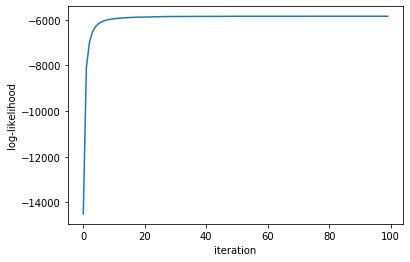

In [94]:
lmf1 = LogisticMF_without_track(R,0.7)
lmf1.train_model()
M1 = lmf1.user_vectors.dot(lmf1.item_vectors.T)
without_track_prob = sigmoid(M1)
result_without = np.multiply(without_track_prob, observed)
PMF = result_without[result_without != 0]

## PMF2

/Users/ruixue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log
/Users/ruixue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply


-inf
iteration 1 finished in 21.530222 seconds
-inf
iteration 2 finished in 17.164246 seconds
-9542.14743131942
iteration 3 finished in 15.739622 seconds
-inf
iteration 4 finished in 15.761093 seconds
-7677.053537237587
iteration 5 finished in 15.752057 seconds
-8494.391785650128
iteration 6 finished in 15.802348 seconds
-10200.775627486124
iteration 7 finished in 15.701974 seconds
-13945.046635953855
iteration 8 finished in 15.693982 seconds
-7971.565123382584
iteration 9 finished in 15.864983 seconds
-6979.377582899004
iteration 10 finished in 15.836877 seconds
-6870.5248002810995
iteration 11 finished in 15.700049 seconds
-6764.26951065389
iteration 12 finished in 16.850569 seconds
-6674.501700759997
iteration 13 finished in 16.253290 seconds
-6589.207894922007
iteration 14 finished in 15.906809 seconds
-6512.133033651113
iteration 15 finished in 16.130262 seconds
-6439.155517229103
iteration 16 finished in 18.855609 seconds
-6371.457895847386
iteration 17 finished in 18.090517 seco

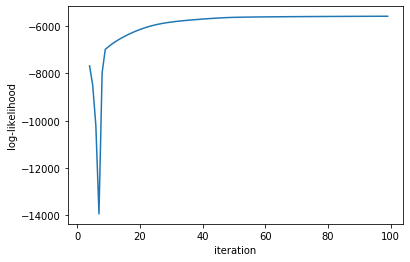

In [79]:
lmf2 = LogisticMF_with_track(R,0.1)
lmf2.train_model()
M2 = lmf2.user_vectors.dot(np.dot(lmf2.item_vectors.T,track.T))
with_track_prob = sigmoid(M2)
result_with = np.multiply(with_track_prob, observed)
PMF_t = result_with[result_with != 0]

## PMF3

iteration 1 finished in 34.630576 seconds
-8328.8915466177
iteration 2 finished in 30.764146 seconds
-7832.588565353854
iteration 3 finished in 24.774150 seconds
-7477.7269086570805
iteration 4 finished in 20.424028 seconds
-7214.61315534727
iteration 5 finished in 20.107632 seconds
-7016.931706672021
iteration 6 finished in 20.015174 seconds
-6868.264273722695
iteration 7 finished in 20.861193 seconds
-6756.824380758628
iteration 8 finished in 21.137865 seconds
-6673.529397244748
iteration 9 finished in 29.373797 seconds
-6611.288981062387
iteration 10 finished in 22.058912 seconds
-6564.645410204383
iteration 11 finished in 26.929136 seconds
-6529.482622292191
iteration 12 finished in 30.118194 seconds
-6502.751228341083
iteration 13 finished in 25.932105 seconds
-6482.220265421386
iteration 14 finished in 19.769341 seconds
-6466.269248019881
iteration 15 finished in 19.877586 seconds
-6453.724172288603
iteration 16 finished in 25.554215 seconds
-6443.733570260184
iteration 17 finish

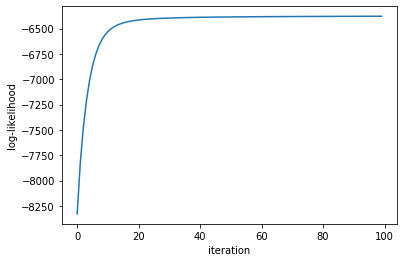

In [62]:

theta,U = grad_descent(X_train_pmf,y_train,session_id_dict,0.3)
UU = [U[session_id_dict[j]] for j in np.asarray(X_test_pmf)[:,-1]]
UU = np.mat(UU,dtype = float)
Xfai = np.mat(np.dot( np.asarray(X_test_pmf)[:,:-1],theta),dtype=float)
PMF_ut = sigmoid(np.multiply(UU,Xfai))


# Logistic Regression model

## LR1

In [81]:
binomial_model1 = sm.GLM(y_train,X_train_track,  family=sm.families.Binomial()).fit()
LR_t = binomial_model1.predict(X_test_track)

## LR2

In [82]:
binomial_model2 = sm.GLM(y_train,X_train_user,  family=sm.families.Binomial()).fit()
LR_u = binomial_model2.predict(X_test_user)

## LR3

In [83]:
binomial_model3 = sm.GLM(y_train,X_train_ut,  family=sm.families.Binomial()).fit()
LR_ut = binomial_model3.predict(X_test_ut)

# Cosine Similarity-Based Filtering

In [91]:
from sklearn.metrics.pairwise import cosine_similarity
train_cs = train_data.drop(['session_id', 'session_position', 'track_id','skip_2','user_behavior','user_id_index','track_id_index'] ,axis = 1)
train_cs = pd.concat([train_data['user_id_index'], train_cs.multiply(train_data['user_behavior'], axis="index")] , axis = 1)
user_profile_all = train_cs.groupby('user_id_index').sum()
user_profile = user_profile_all.iloc[:,19:]
t_profile = track
cosine_sim = cosine_similarity(np.asarray(user_profile), t_profile)
test_cs = T[~np.isnan(T)]
Predicted = cosine_sim[~np.isnan(T)]

# Evaluation 

PMF1 0.5257536042821929
PMF2 0.7336252031174063
PMF3 0.7347761639195936
LR1 0.5375841737361928
LR2 0.8051802128664711
LR3  0.8044360609894268
CS 0.5285169433909938


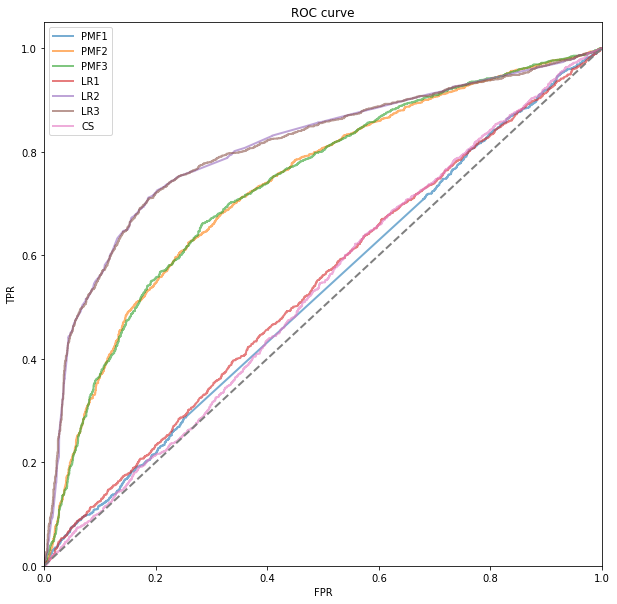

In [97]:

#PMF 

# plain
fpr_pmf1, tpr_pmf1, thresholds_pmf1 = metrics.roc_curve(test_pmf,PMF)  
roc_auc_pmf1 = metrics.auc(fpr_pmf1, tpr_pmf1)
# track
fpr_pmf2, tpr_pmf2, thresholds_pmf2 = metrics.roc_curve(test_pmf,PMF_t)
roc_auc_pmf2 = metrics.auc(fpr_pmf2, tpr_pmf2)
# user and track
fpr_pmf3, tpr_pmf3, thresholds_pmf3 = metrics.roc_curve(y_test,PMF_ut)
roc_auc_pmf3 = metrics.auc(fpr_pmf3, tpr_pmf3)


# LR

# user
fpr_lr1, tpr_lr1, thresholds_lr1 = metrics.roc_curve(y_test,LR_t)  
roc_auc_lr1 = metrics.auc(fpr_lr1, tpr_lr1)
# track
fpr_lr2, tpr_lr2, thresholds_lr2 = metrics.roc_curve(y_test,LR_u)
roc_auc_lr2 = metrics.auc(fpr_lr2, tpr_lr2)
# user and track
fpr_lr3, tpr_lr3, thresholds_lr3 = metrics.roc_curve(y_test,LR_ut)
roc_auc_lr3 = metrics.auc(fpr_lr3, tpr_lr3)

#CS
fpr_cs, tpr_cs, thresholds_cs = metrics.roc_curve(test_cs,Predicted)
roc_auc_cs = metrics.auc(fpr_cs, tpr_cs)


print('PMF1', roc_auc_pmf1)
print('PMF2', roc_auc_pmf2)
print('PMF3', roc_auc_pmf3)

print('LR1',roc_auc_lr1  )
print('LR2',roc_auc_lr2 )
print('LR3 ',roc_auc_lr3  )

print('CS',roc_auc_cs)

_=plt.figure(figsize=(10,10))
plt.plot(fpr_pmf1, tpr_pmf1,fpr_pmf2, tpr_pmf2,fpr_pmf3, tpr_pmf3,fpr_lr1, tpr_lr1,fpr_lr2, tpr_lr2,fpr_lr3, tpr_lr3, fpr_cs, tpr_cs, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(labels=['PMF1', 'PMF2','PMF3','LR1','LR2','LR3','CS'])
plt.show()

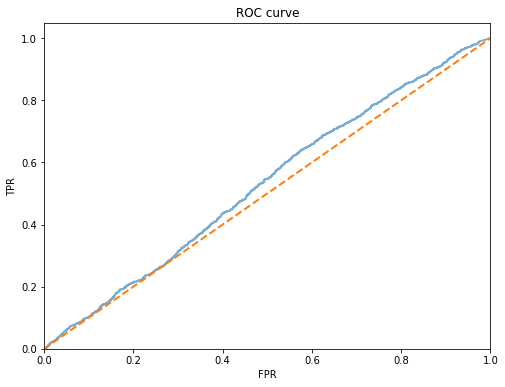

In [98]:
_=plt.figure(figsize=(8,6))
plt.plot(fpr_cs, tpr_cs, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

pmf plain 0.5257536042821929
pmf with track 0.7336252031174063
pmf with user and track 0.7347761639195936


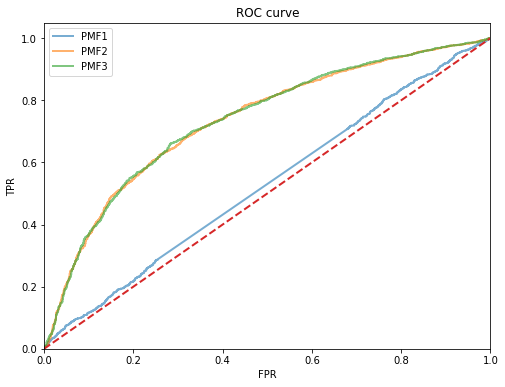

In [99]:
print('pmf plain', roc_auc_pmf1)
print('pmf with track', roc_auc_pmf2)
print('pmf with user and track', roc_auc_pmf3)

_=plt.figure(figsize=(8,6))
plt.plot(fpr_pmf1, tpr_pmf1,fpr_pmf2, tpr_pmf2,fpr_pmf3, tpr_pmf3, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(labels=['PMF1', 'PMF2','PMF3'])
plt.show()

LR with track 0.5375841737361928
LR with user 0.8051802128664711
LR with user and track 0.8044360609894268


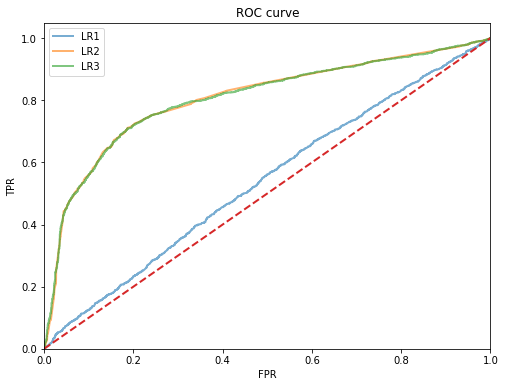

In [100]:
print('LR with track',roc_auc_lr1)
print('LR with user',roc_auc_lr2)
print('LR with user and track',roc_auc_lr3)

_=plt.figure(figsize=(8,6))
plt.plot(fpr_lr1, tpr_lr1,fpr_lr2, tpr_lr2,fpr_lr3, tpr_lr3, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(labels=['LR1','LR2','LR3'])
plt.show()

pmf with track 0.7336252031174063
LR with track 0.8051802128664711
content based cosine similarity 0.5285169433909938


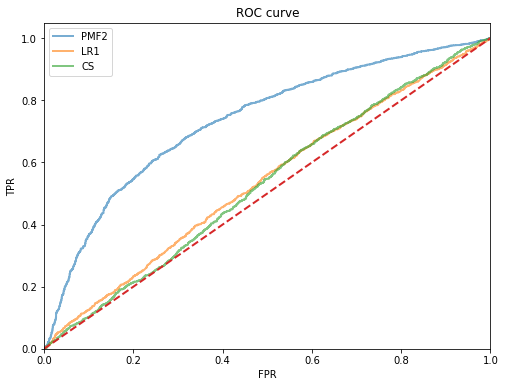

In [101]:
print('pmf with track', roc_auc_pmf2)
print('LR with track',roc_auc_lr2 )
print('content based cosine similarity',roc_auc_cs)
_=plt.figure(figsize=(8,6))
plt.plot(fpr_pmf2, tpr_pmf2,fpr_lr1, tpr_lr1,fpr_cs, tpr_cs, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(labels=['PMF2','LR1','CS'])
plt.show()

pmf with user and track 0.7347761639195936
LR with user and track 0.8044360609894268


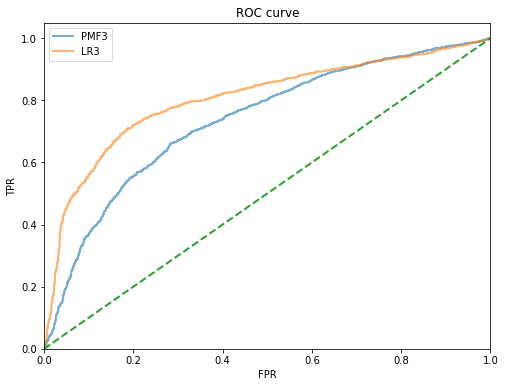

In [102]:
print('pmf with user and track', roc_auc_pmf3)
print('LR with user and track',roc_auc_lr3 )

_=plt.figure(figsize=(8,6))
plt.plot(fpr_pmf3, tpr_pmf3,fpr_lr3, tpr_lr3, lw=2, alpha=.6)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(labels=['PMF3','LR3'])
plt.show()